In [ ]:
import random
import cv2
import os
import numpy
import math
num_images = 2700

def euler_to_mat(yaw, pitch, roll):
    # Rotate clockwise about the Y-axis
    c, s = math.cos(yaw), math.sin(yaw)
    M = numpy.matrix([[  c, 0.,  s],
                      [ 0., 1., 0.],
                      [ -s, 0.,  c]])

    # Rotate clockwise about the X-axis
    c, s = math.cos(pitch), math.sin(pitch)
    M = numpy.matrix([[ 1., 0., 0.],
                      [ 0.,  c, -s],
                      [ 0.,  s,  c]]) * M

    # Rotate clockwise about the Z-axis
    c, s = math.cos(roll), math.sin(roll)
    M = numpy.matrix([[  c, -s, 0.],
                      [  s,  c, 0.],
                      [ 0., 0., 1.]]) * M

    return M

def make_affine_transform(from_shape, to_shape,
                          min_scale, max_scale,
                          scale_variation=1.0,
                          rotation_variation=1.0,
                          translation_variation=1.0):
    out_of_bounds = False

    from_size = numpy.array([[from_shape[1], from_shape[0]]]).T
    to_size = numpy.array([[to_shape[1], to_shape[0]]]).T

    scale = random.uniform((min_scale + max_scale) * 0.5 -
                           (max_scale - min_scale) * 0.5 * scale_variation,
                           (min_scale + max_scale) * 0.5 +
                           (max_scale - min_scale) * 0.5 * scale_variation)
    if scale > max_scale or scale < min_scale:
        out_of_bounds = True
    roll = random.uniform(-0.3, 0.3) * rotation_variation
    pitch = random.uniform(-0.2, 0.2) * rotation_variation
    yaw = random.uniform(-1.2, 1.2) * rotation_variation

    # Compute a bounding box on the skewed input image (`from_shape`).
    M = euler_to_mat(yaw, pitch, roll)[:2, :2]
    h, w = from_shape
    corners = numpy.matrix([[-w, +w, -w, +w],
                            [-h, -h, +h, +h]]) * 0.5
    skewed_size = numpy.array(numpy.max(M * corners, axis=1) -
                              numpy.min(M * corners, axis=1))

    scale *= numpy.min(to_size / skewed_size)

    trans = (numpy.random.random((2,1)) - 0.5) * translation_variation
    trans = ((2.0 * trans) ** 5.0) / 2.0
    if numpy.any(trans < -0.5) or numpy.any(trans > 0.5):
        out_of_bounds = True
    trans = (to_size - skewed_size * scale) * trans

    center_to = to_size / 2.
    center_from = from_size / 2.

    M = euler_to_mat(yaw, pitch, roll)[:2, :2]
    M *= scale
    M = numpy.hstack([M, trans + center_to - M * center_from])

    return M, out_of_bounds



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

for i in range(0,num_images):
    f=random.choice(os.listdir('/content/gdrive/My Drive/Computer_vision_IPL/train/'))
    logoI = cv2.imread('/content/gdrive/My Drive/Computer_vision_IPL/train/'+f)
    logo = cv2.cvtColor(logoI, cv2.COLOR_BGR2GRAY)

    scale = 1;#random.randint(0,5)
    if scale!=0 and ((logo.shape[0]/scale)>10):
        M, out_of_bounds = make_affine_transform(
                            from_shape=logo.shape,
                            to_shape=logo.shape,
                            min_scale=1,
                            max_scale=1,
                            rotation_variation=1.0,
                            scale_variation=1.5,
                            translation_variation=1.2)

        im = cv2.warpAffine(logo,M,logo.shape,255)

        print('/content/gdrive/My Drive/Computer_vision_IPL/augmented/' + str(i) + '_' + f)
        cv2.imwrite('/content/gdrive/My Drive/Computer_vision_IPL/augmented/'+str(i)+'_'+f, im)
    else:
        print ('augmentedData/'+str(i)+'_'+f)
        cv2.imwrite('augmentedData/'+str(i)+'_'+f, im)

In [ ]:
print(logo.shape)


(124, 300)


In [ ]:
import cv2
import numpy as np
import os

detector = cv2.xfeatures2d.SIFT_create(60)

uarray = [4]  # Can be used to tune hyperparameters
tharray = [0.65]
for u in uarray:
    for th in tharray:
        kps2 = []
        descs2 = []
        brand = []
        MAX_LIMIT = 1
        files = os.listdir('/content/gdrive/My Drive/Computer_vision_IPL/train/')
        # Store the descriptors for all the logos
        for f in files:
            logoI = cv2.imread('/content/gdrive/My Drive/Computer_vision_IPL/train/' + f)
            logo = cv2.cvtColor(logoI, cv2.COLOR_BGR2GRAY)
            (kps, descs) = detector.detectAndCompute(logo, None)
            kps2.append(kps)
            descs2.append(descs)
            brand.append(f.split('.')[0])

        files = os.listdir('/content/gdrive/My Drive/Computer_vision_IPL/augmented/')
        for f in files:  # Add synthetic images to the logos
            logoI = cv2.imread('/content/gdrive/My Drive/Computer_vision_IPL/augmented/' + f)
            logo = cv2.cvtColor(logoI, cv2.COLOR_BGR2GRAY)
            (kps, descs) = detector.detectAndCompute(logo, None)
            kps2.append(kps)
            descs2.append(descs)
            brand.append(f.split('_')[1].split('.')[0])

        # Read probes.txt file
        with open('/content/gdrive/My Drive/Computer_vision_IPL/probes.txt') as f:
            lines = f.readlines()

        # Process the probes.txt file line by line
        actualBrand = []
        logoMatchList = []
        for line in lines:
            hashMap = {}
            logoMatch = []
            filename = line.split("\t")[0]
            brandname = line.split("\t")[1].strip()
            probeI = cv2.imread('/content/gdrive/My Drive/Computer_vision_IPL/test/' + filename)
            probe = cv2.cvtColor(probeI, cv2.COLOR_BGR2GRAY)
            (kps1, descs1) = detector.detectAndCompute(probe, None)
            i = 0
            for d, kp in zip(descs2, kps2):
                bf = cv2.BFMatcher()
                matches = bf.knnMatch(d, descs1, k=3)

                # Ratio test to identify good matches
                good = []
                for m, n, k in matches:
                    if m.distance < th * n.distance:
                        good.append(m)
                good = sorted(good, key=lambda val: val.distance)

                if len(good) > u:
                    if hashMap.get(brand[i]) is None:
                        hashMap[brand[i]] = 1
                    else:
                        break
                    src_pts = np.float32([kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
                    dst_pts = np.float32([kps1[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

                    # Get homography to draw the bounding box
                    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 8.0)
                    if mask is not None:
                        matchesMask = mask.ravel().tolist()
                        logoMatch.append(brand[i])
                        h, w = logo.shape
                        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                        dst = cv2.perspectiveTransform(pts, M)

                        probe = cv2.polylines(probe, [np.int32(dst)], True, (0, 0, 255), 3, cv2.LINE_AA)
                        cv2.imwrite('matchResults/' + filename + '_' + brand[i] + '_out.png', probe)
                    else:
                        matchesMask = None
                i += 1
            logoMatchList.append(logoMatch)
            actualBrand.append(brandname)

        # Computing accuracy
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        i = 0

        for brands in logoMatchList:
            for brand in brands:
                if brand == actualBrand[i]:
                    tp += 1
                else:
                    fp += 1
            i += 1
        i = 0

        for brands in logoMatchList:
            if brands == []:
                if actualBrand[i] == 'none':
                    tn += 1
                else:
                    fn += 1
            i += 1
        print("Accuracy =", str((tp + tn) / (tp + tn + fp + fn)))


In [ ]:
# Get homography to draw the bounding box
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 8.0)

# Check if M is not None and has shape (3, 3)
if M is not None and M.shape == (3, 3):
    # Apply perspective transformation
    dst = cv2.perspectiveTransform(pts, M)
    # Draw bounding box
    if mask is not None:
        matchesMask = mask.ravel().tolist()
        logoMatch.append(brand[i])
        h, w = logo.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        probe = cv2.polylines(probe, [np.int32(dst)], True, (0, 0, 255), 3, cv2.LINE_AA)
        cv2.imwrite('matchResults/' + filename + '_' + brand[i] + '_out.png', probe)
    else:
        matchesMask = None
else:
    print("Homography matrix M is None or has incorrect shape.")


Homography matrix M is None or has incorrect shape.


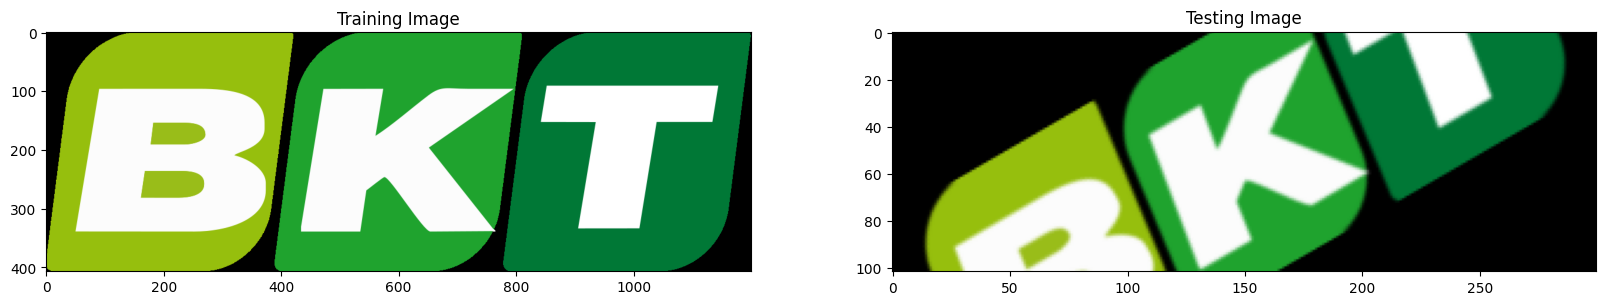

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
image1 = cv2.imread('BKT 1.png')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  69
Number of Keypoints Detected In The Query Image:  27


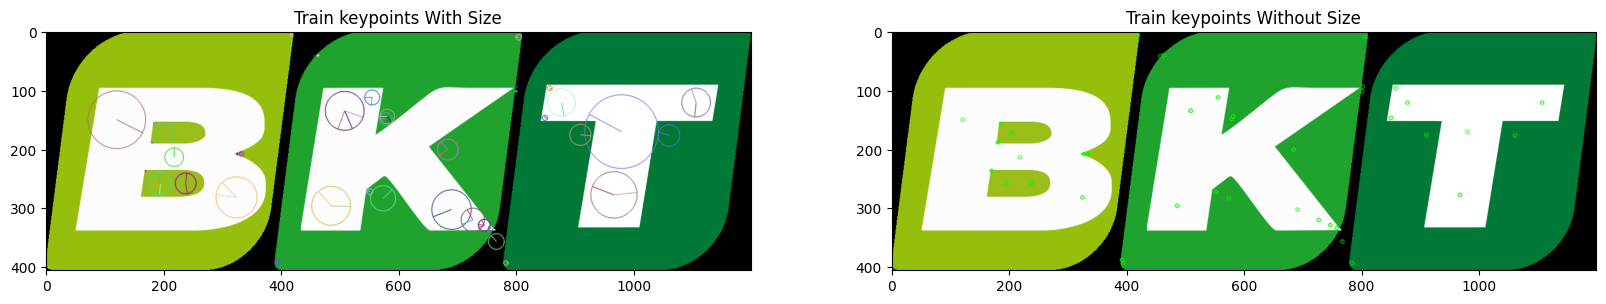

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

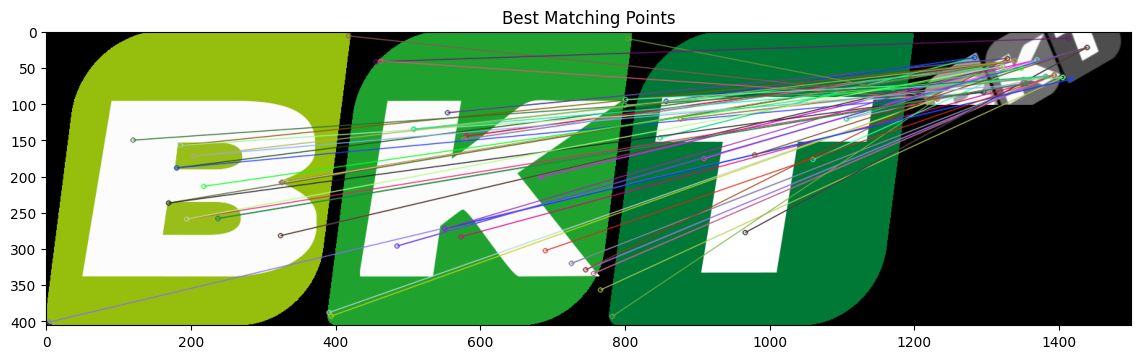


Number of Matching Keypoints Between The Training and Query Images:  69


In [ ]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

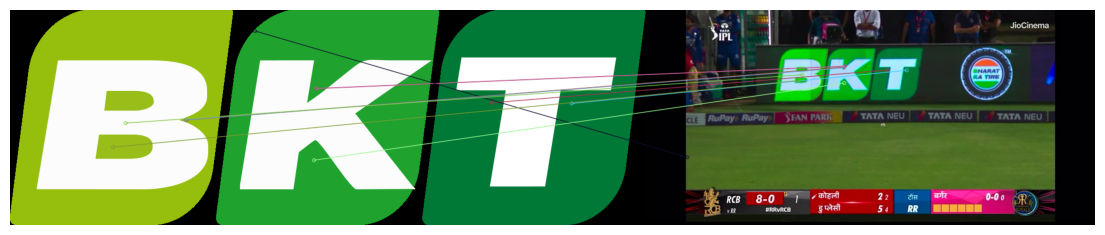

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the train image
train_image = cv2.imread('BKT 1.png')
train_image_rgb = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
train_gray = cv2.cvtColor(train_image_rgb, cv2.COLOR_RGB2GRAY)

# Load the test image
test_image = cv2.imread('frame_53.jpg')
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_gray = cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2GRAY)

# Create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Detect keypoints and create descriptors for train and test images
train_keypoints, train_descriptor = sift.detectAndCompute(train_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# Match descriptors
matches = bf.match(train_descriptor, test_descriptor)

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
matching_result = cv2.drawMatches(train_image_rgb, train_keypoints, test_image_rgb, test_keypoints, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matching result
plt.imshow(matching_result)
plt.axis('off')
plt.show()


In [ ]:
match.distance < 0.75 * query_idx

False